# Navigation

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

A plot of rewards per episode is included to illustrate that the agent is able to receive an average reward (over 100 episodes) of at least +13. The submission reports the number of episodes needed to solve the environment.

Train the agent by executing each cell.

## 1. Setup Environment


In [1]:
from unityagents import UnityEnvironment
from my_dqn_agent import Agent
import random
import torch
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

# Environments contain brains which are responsible for deciding the actions 
# of their associated agents. Here we check for the first brain available, 
# and set it as the default brain we will be controlling from Python

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

# initialize agent
agent = Agent(state_size, action_size)

Device:  cuda:0


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 2. Deep Q-Learning Agent

Episode 100	Average Score: -0.11
Episode 200	Average Score: 2.801
Episode 300	Average Score: 5.14
Episode 400	Average Score: 8.22
Episode 500	Average Score: 12.38
Episode 600	Average Score: 14.33
Episode 635	Average Score: 15.06
Environment solved in 635 episodes!	Average Score: 15.06


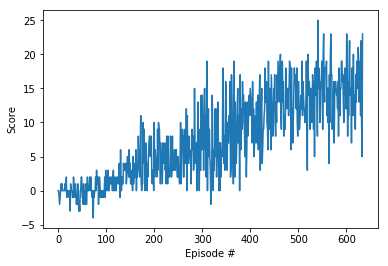

In [2]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):                        # start episode 
        env_info = env.reset(train_mode=True)[brain_name]           # reset unity environment and learn
        state = env_info.vector_observations[0]                     # get the current state
        score = 0                                                   # reset score per episode
        for t in range(max_t):
            action = agent.act(state, eps)                          # dqn_agent selects an action 
            env_info = env.step(action)[brain_name]                 # send the action to unity environment 
            next_state = env_info.vector_observations[0]            # get the next state from environment
            reward = env_info.rewards[0]                            # get the reward from environment
            done = env_info.local_done[0]                           # see if episode has finished
            agent.step(state, action, reward, next_state, done)     # dqn_agent performs next step
            state = next_state                                      # set new state
            score += reward                                         # update score
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=15.0:  # An average of 15 can be obtained only going 200 episodes more
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'trained_neuralnetwork.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 3. Replay

In [4]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('trained_neuralnetwork.pth'))

env_info = env.reset(train_mode=False)[brain_name]       # reset unity environment and learning prohibited
state = env_info.vector_observations[0]                  # get the current state from unity environment
score = 0                                                # initialize score
while True:
    action = agent.act(state)                            # dqn_agent selects an action 
    env_info = env.step(action)[brain_name]              # action is provided to environment
    next_state = env_info.vector_observations[0]         # environment determines next state
    reward = env_info.rewards[0]                         # get the reward from environment
    done = env_info.local_done[0]                        # see if episode has finished
    score += reward                                      # update the score
    agent.step(state, action, reward, next_state, done)  # dqn_agent performs steps
    state = next_state                                   # set new state
    if done:                                             # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 16.0
